In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torchinfo import summary

from src.datasets import BiosensorDataset, create_datasets
from src.model_parts import *
from src.models import *
# from src.train_tiling import train_model, evaluate
from src.train import train_model
from src.evaluate import evaluate
from src.utils import *

c:\Users\wittd\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

torch.manual_seed(42)
np.random.seed(42)

batch_size = 8
upscale_factor = 4

config = {
    'path': 'C:/onlab_git/Onlab/data_with_centers/',
    'mask_type': bool,
    'augment': False,
    'noise': 0.0,
    'dilation': 0,
    'tiling': True,
    'tiling_ratio': 8,
}

create_dataset_args = {
    'train_percent': 0.59,
    'test_percent': 0.215,
}

calc_config = {
    'biosensor_length': 8,
    'mask_size': 80 * upscale_factor,
    'input_scaling': True,
    'upscale_mode': 'nearest',
}

train_dataset, val_dataset, test_dataset = create_datasets(config, create_dataset_args, calc_config)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Train size:', len(train_dataset))
print('Validation size:', len(val_dataset))
print('Test size:', len(test_dataset))

Using device cuda
Train size: 96
Validation size: 32
Test size: 35


In [3]:
model = UNet(n_channels=calc_config['biosensor_length'], n_classes=1, down_conv=DoubleConv, up_conv=DoubleConv, bilinear=True)
# model = UNet4(n_channels=calc_config['biosensor_length'], n_classes=1, down_conv=SingleConv, up_conv=SingleConv, bilinear=False)
model = model.to(device)
print(model.__class__.__name__)
project_name = "Testing tiling"
model_name = "UNet_320_double_conv"
# model_name = "SRUNet4_double_conv"

model_summary = summary(model)
print(model_summary.trainable_params)

UNet
13394241


In [4]:
# 8as tile ratio -> 10x10es tile ami eltűnik a z 512es channel sizenál a sok felezés miatt
# enniy erővel a 10es is jó mert az 8x8
# túl mély a model

In [5]:
try:
    train_model(
        model,
        project_name,
        model_name,
        device,
        train_loader,
        val_loader,
        learning_rate=0.01,
        epochs=20,
        checkpoint_dir='test_saves',
        amp=True,
        wandb_logging=True,
        tile_ratio=config['tiling_ratio'],
    )
except torch.cuda.OutOfMemoryError:
    torch.cuda.empty_cache()
    print('Detected OutOfMemoryError!')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: wdavid (wdave). Use `wandb login --relogin` to force relogin


Starting training:
        Epochs:          20
        Batch size:      8
        Learning rate:   0.01
        Training size:   96
        Validation size: 32
        Device:          cuda
        Mixed Precision: True
    


Validation Dice score: 0.38004234433174133, Detection rate: 0.39835841313269493


Epoch 1/20: 100%|██████████| 96/96 [00:17<00:00,  5.60img/s, loss (batch)=1.09]


Checkpoint 1 saved!


Validation Dice score: 0.29374927282333374, Detection rate: 0.00984952120383037


Epoch 2/20: 100%|██████████| 96/96 [00:16<00:00,  5.75img/s, loss (batch)=0.997]


Checkpoint 2 saved!


Validation Dice score: 0.29158079624176025, Detection rate: 0.005745554035567715


Epoch 3/20: 100%|██████████| 96/96 [00:17<00:00,  5.61img/s, loss (batch)=0.913]


Checkpoint 3 saved!


Validation Dice score: 0.299385666847229, Detection rate: 0.4161422708618331


Epoch 4/20: 100%|██████████| 96/96 [00:16<00:00,  5.75img/s, loss (batch)=0.924]


Checkpoint 4 saved!


Validation Dice score: 0.3613399267196655, Detection rate: 0.25690834473324214


Epoch 5/20: 100%|██████████| 96/96 [00:17<00:00,  5.64img/s, loss (batch)=0.842]


Checkpoint 5 saved!


Validation Dice score: 0.3264223337173462, Detection rate: 0.19233926128590972


Epoch 6/20: 100%|██████████| 96/96 [00:16<00:00,  5.68img/s, loss (batch)=0.861]


Checkpoint 6 saved!


Validation Dice score: 0.37719976902008057, Detection rate: 0.3972640218878249


Epoch 7/20: 100%|██████████| 96/96 [00:15<00:00,  6.27img/s, loss (batch)=0.934]


Checkpoint 7 saved!


Validation Dice score: 0.39714106917381287, Detection rate: 0.40383036935704514


Epoch 8/20: 100%|██████████| 96/96 [00:15<00:00,  6.30img/s, loss (batch)=0.875]


Checkpoint 8 saved!


Validation Dice score: 0.4112390875816345, Detection rate: 0.4604651162790698


Epoch 9/20: 100%|██████████| 96/96 [00:16<00:00,  5.99img/s, loss (batch)=0.828]


Checkpoint 9 saved!


Validation Dice score: 0.4218543767929077, Detection rate: 0.520109439124487


Epoch 10/20: 100%|██████████| 96/96 [00:16<00:00,  5.95img/s, loss (batch)=0.771]


Checkpoint 10 saved!


Validation Dice score: 0.4296444058418274, Detection rate: 0.5570451436388509


Epoch 11/20: 100%|██████████| 96/96 [00:15<00:00,  6.02img/s, loss (batch)=0.817]


Checkpoint 11 saved!


Validation Dice score: 0.43659287691116333, Detection rate: 0.5518467852257182


Epoch 12/20: 100%|██████████| 96/96 [00:16<00:00,  6.00img/s, loss (batch)=0.719]


Checkpoint 12 saved!


Validation Dice score: 0.44465917348861694, Detection rate: 0.5767441860465117


Epoch 13/20: 100%|██████████| 96/96 [00:16<00:00,  5.96img/s, loss (batch)=0.719]


Checkpoint 13 saved!


Validation Dice score: 0.44718432426452637, Detection rate: 0.5915184678522571


Epoch 14/20: 100%|██████████| 96/96 [00:15<00:00,  6.10img/s, loss (batch)=0.785]


Checkpoint 14 saved!


Validation Dice score: 0.4478680491447449, Detection rate: 0.572640218878249


Epoch 15/20: 100%|██████████| 96/96 [00:15<00:00,  6.03img/s, loss (batch)=0.687]


Checkpoint 15 saved!


Validation Dice score: 0.4563405513763428, Detection rate: 0.613406292749658


Epoch 16/20: 100%|██████████| 96/96 [00:16<00:00,  5.84img/s, loss (batch)=0.713]


Checkpoint 16 saved!


Validation Dice score: 0.45888984203338623, Detection rate: 0.6235294117647059


Epoch 17/20: 100%|██████████| 96/96 [00:15<00:00,  6.00img/s, loss (batch)=0.733]


Checkpoint 17 saved!


Validation Dice score: 0.46200841665267944, Detection rate: 0.5986320109439125


Epoch 18/20: 100%|██████████| 96/96 [00:16<00:00,  5.91img/s, loss (batch)=0.75]


Checkpoint 18 saved!


Validation Dice score: 0.46334534883499146, Detection rate: 0.6016415868673051


Epoch 19/20: 100%|██████████| 96/96 [00:15<00:00,  6.07img/s, loss (batch)=0.717]


Checkpoint 19 saved!


Validation Dice score: 0.46851736307144165, Detection rate: 0.6558139534883721


Epoch 20/20: 100%|██████████| 96/96 [00:19<00:00,  4.96img/s, loss (batch)=0.786]


Checkpoint 20 saved!


detection_rate,▅▁▁▅▄▃▅▅▆▇▇▇▇▇▇██▇▇█
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇██
learning rate,██████▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train loss,█▇█▆▆▆▆▅▄▆▆▄▅▅▇▅▄▄▄▅▃▂▂▃▃▂▃▁▃▃▃▃▂▂▂▃▃▃▁▂
validation Dice,▄▁▁▁▄▂▄▅▆▆▆▇▇▇▇█████
detection_rate,0.65581
epoch,20
learning rate,0.001
step,240
train loss,0.78551


In [ ]:
from torchinfo import summary
model_summary = summary(model, depth=4)
print(model_summary)
# print(model_summary.total_params)
# print(model_summary.trainable_params)

In [6]:
# Load the checkpoint
checkpoint = torch.load("test_saves/checkpoint_epoch20.pth")
# Get the learning rate and remove it from the checkpoint
lr = checkpoint.pop('learning_rate')
# Load the state dictionary into the model
model.load_state_dict(checkpoint)
# Move the model to the device
model = model.to(device)

evaluate_after_training(model, val_loader, test_loader, device)

Validation dice score: 0.46851736307144165, Detection rate: 0.6558139534883721
Test dice score: 0.44127246737480164, Detection rate: 0.5990279465370595


In [23]:
# Saving the best model for production
# model = UNet8(n_channels=8, n_classes=1)
# checkpoint = torch.load("checkpoints/checkpoint_8_4_85.pth")
# lr = checkpoint.pop('learning_rate')
# model.load_state_dict(checkpoint)

# torch.jit.script(model).save('saved_models/srunet8_len8_40dice.pth')

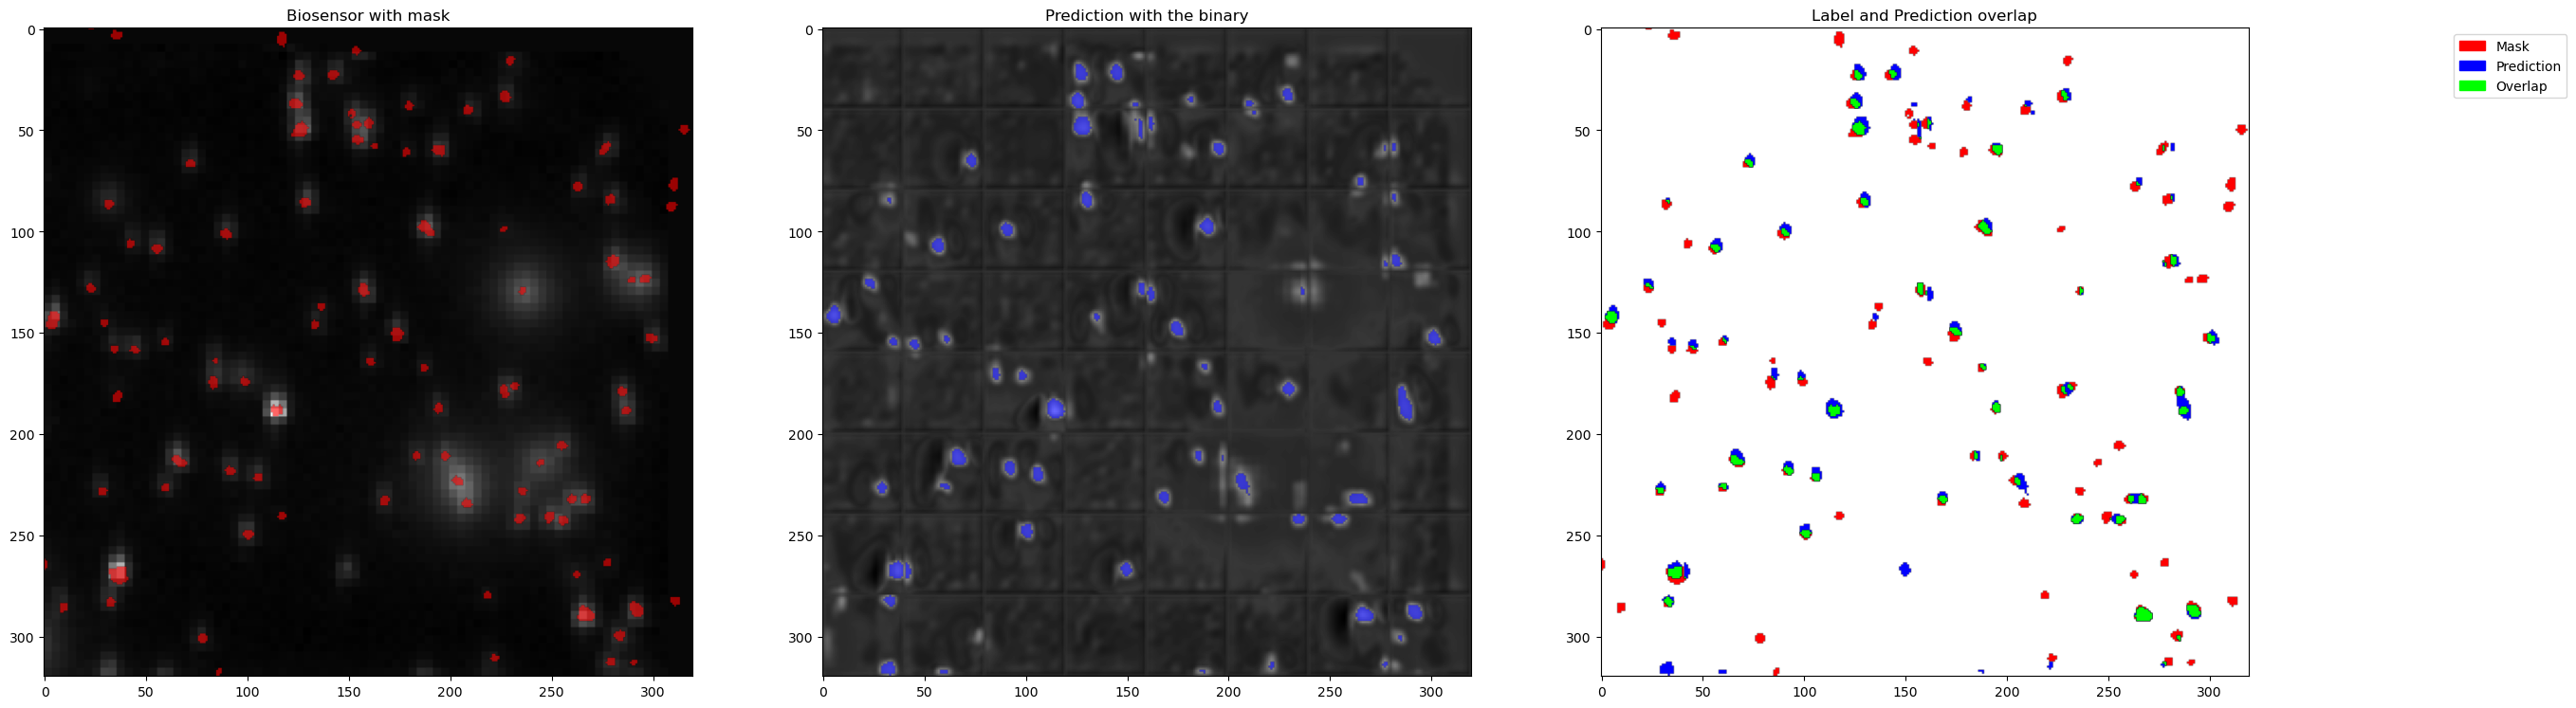

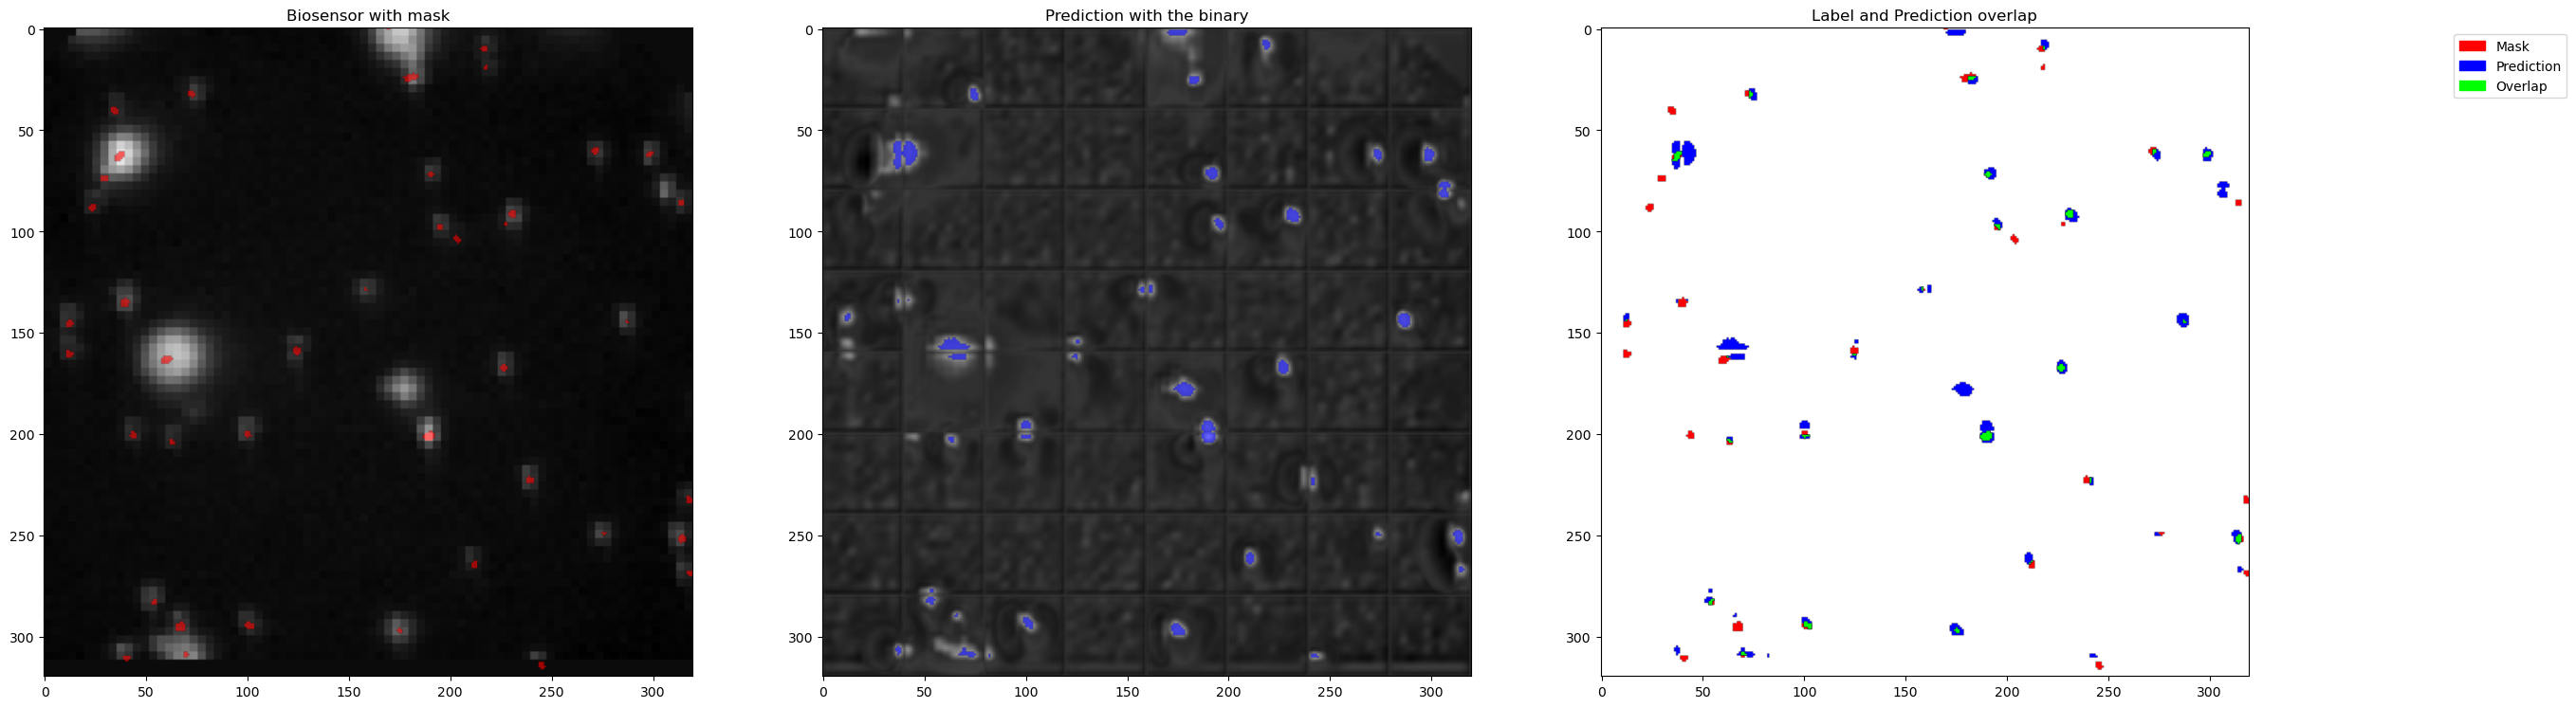

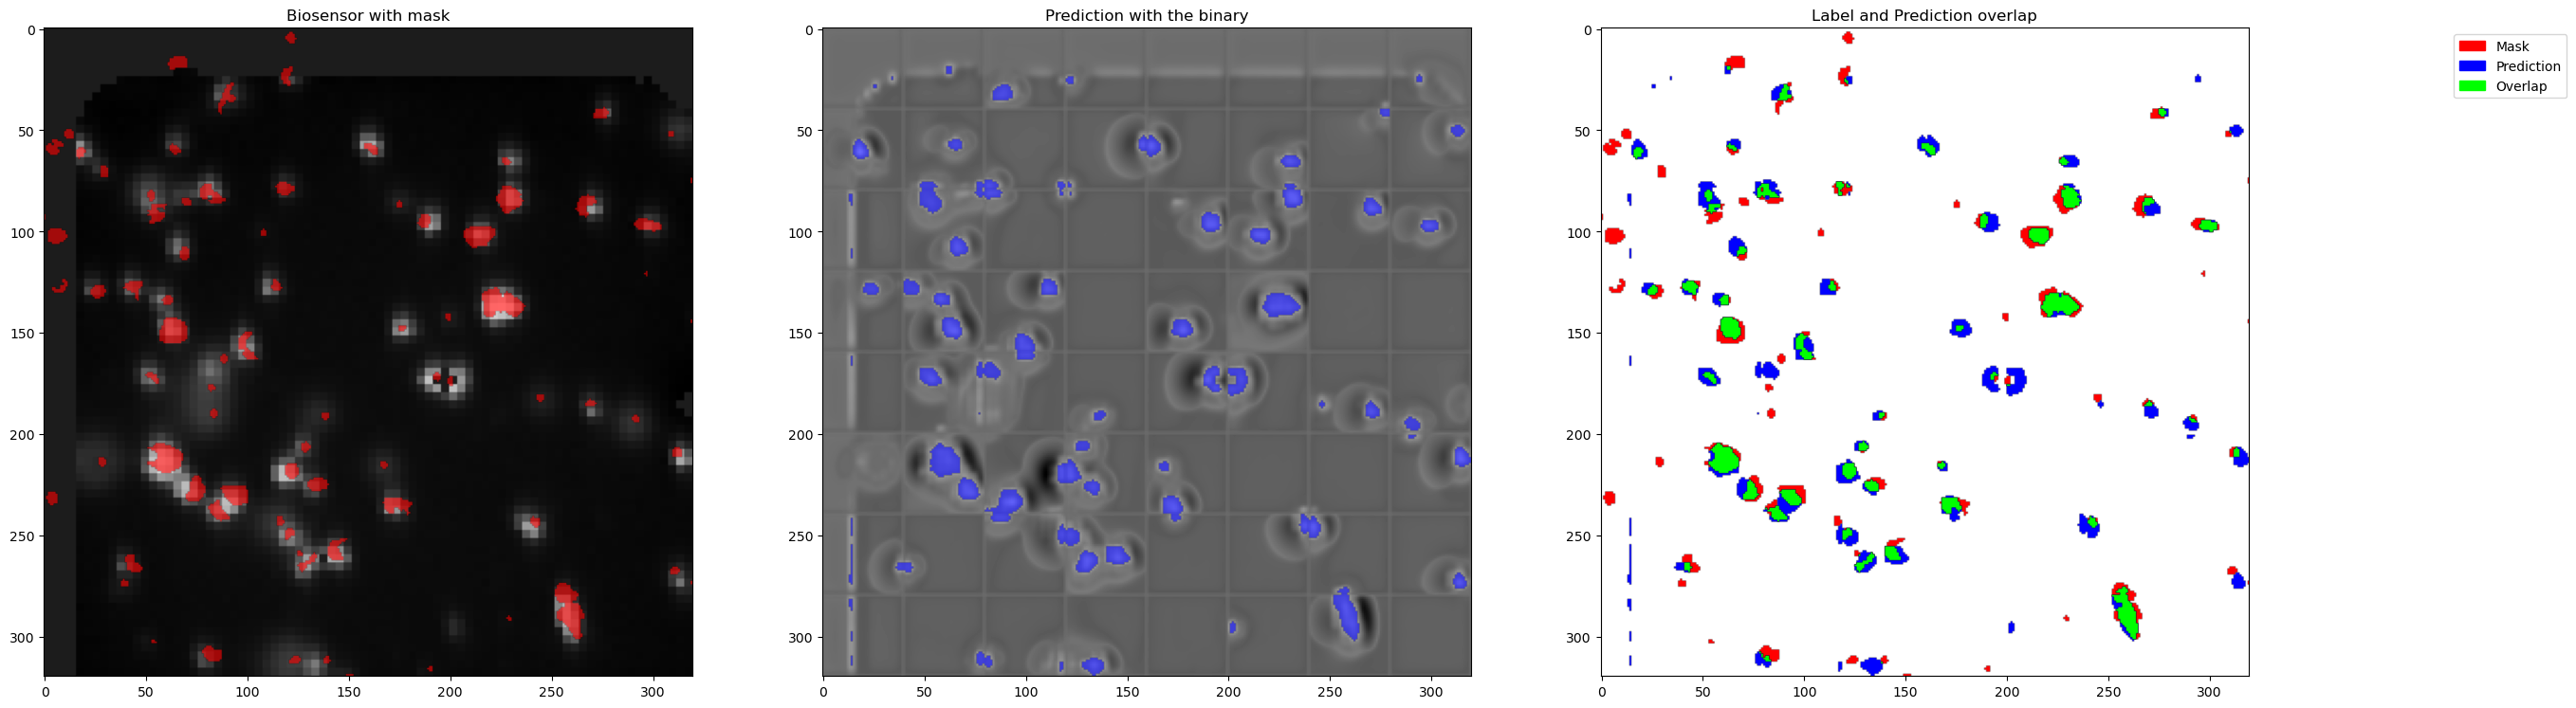

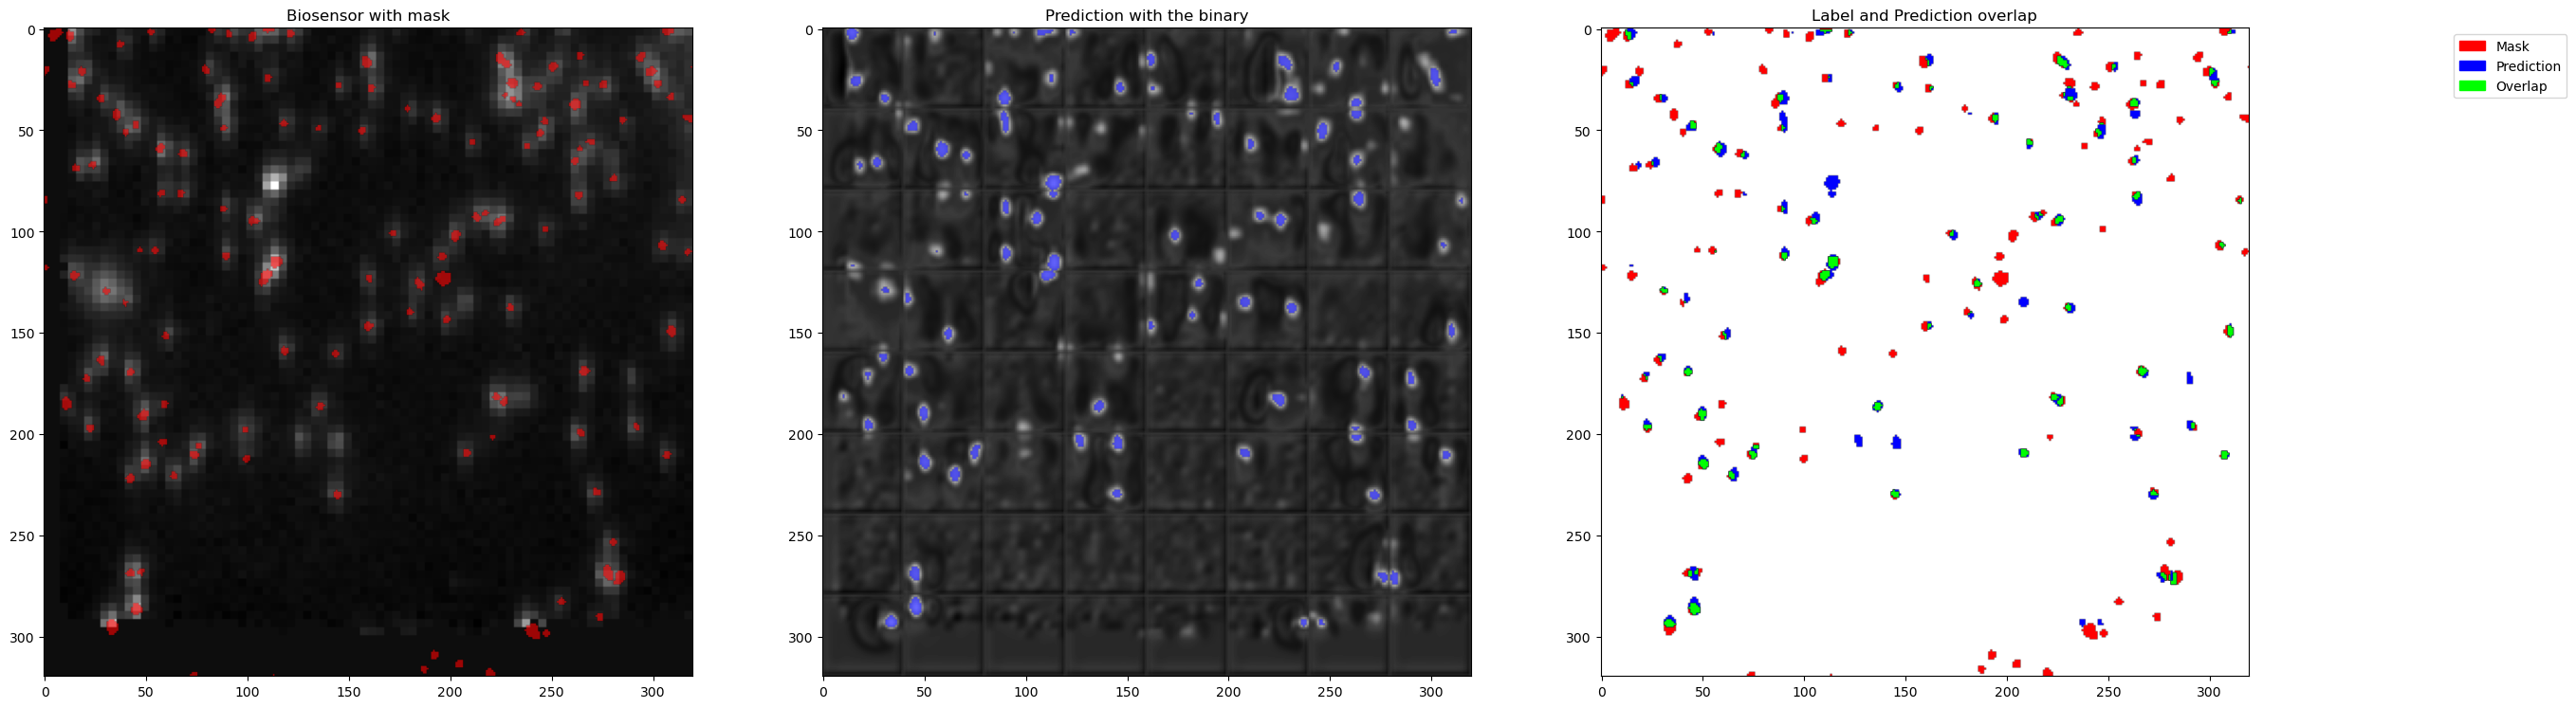

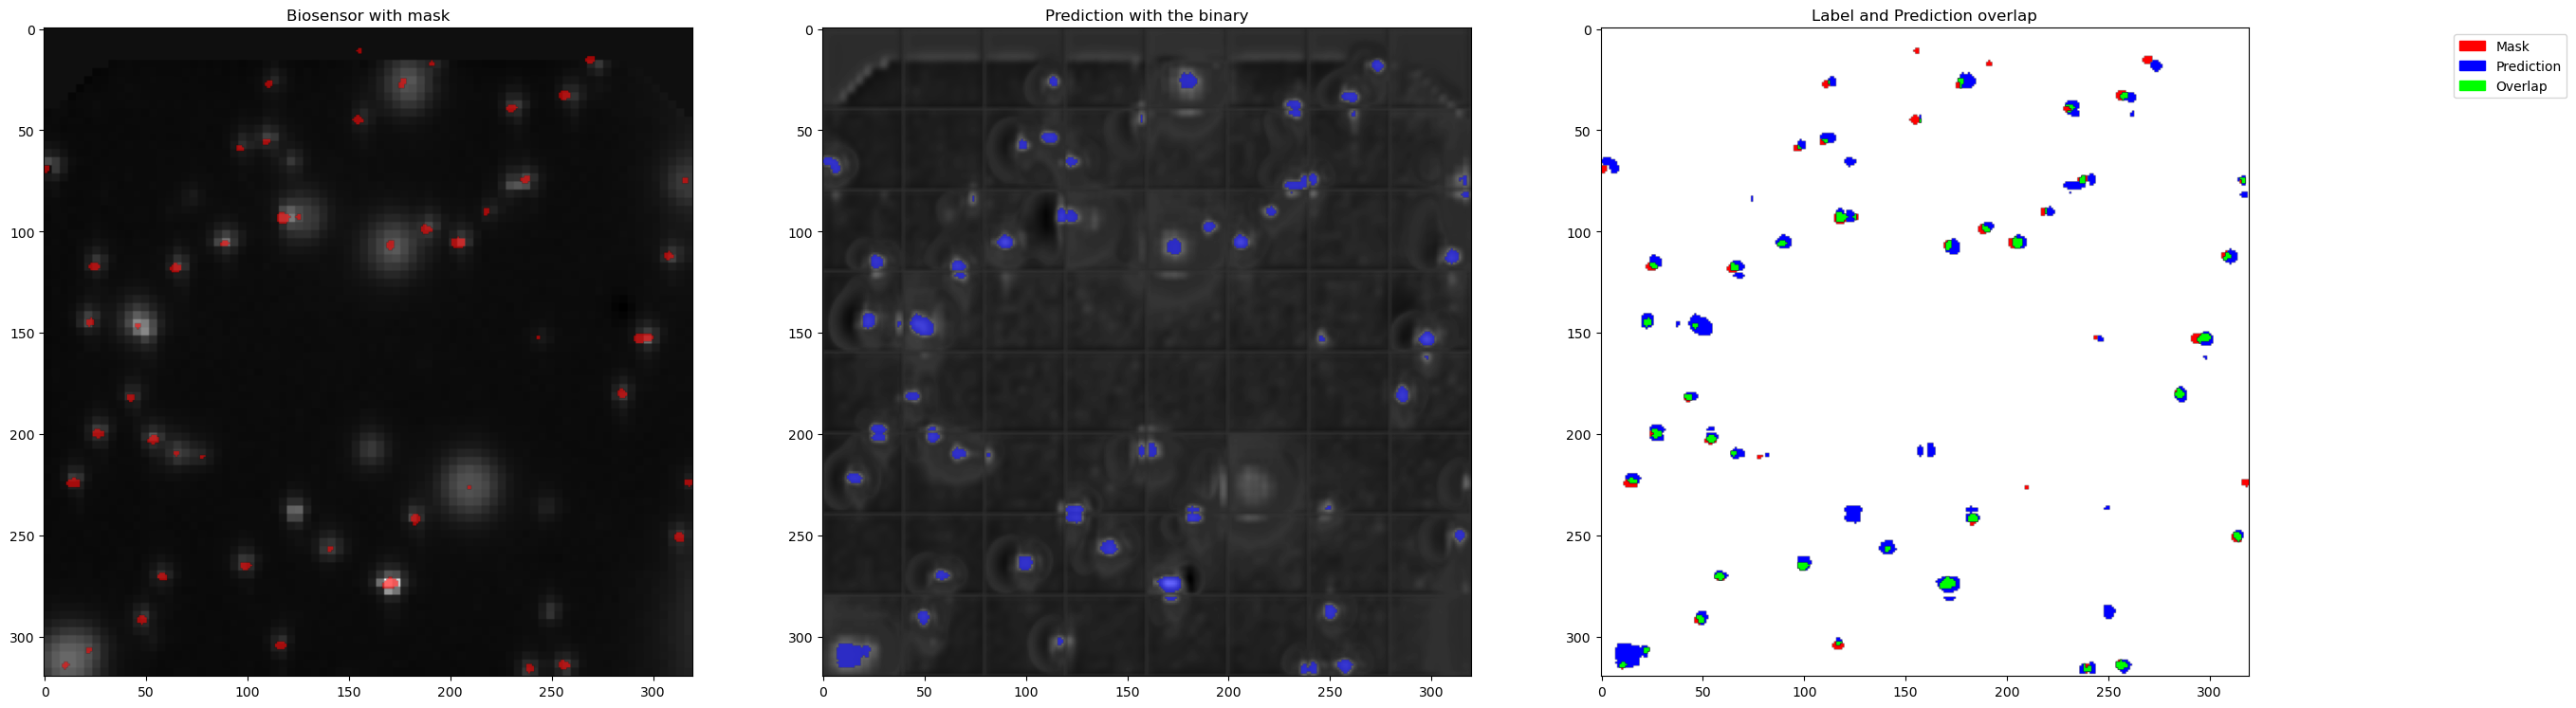

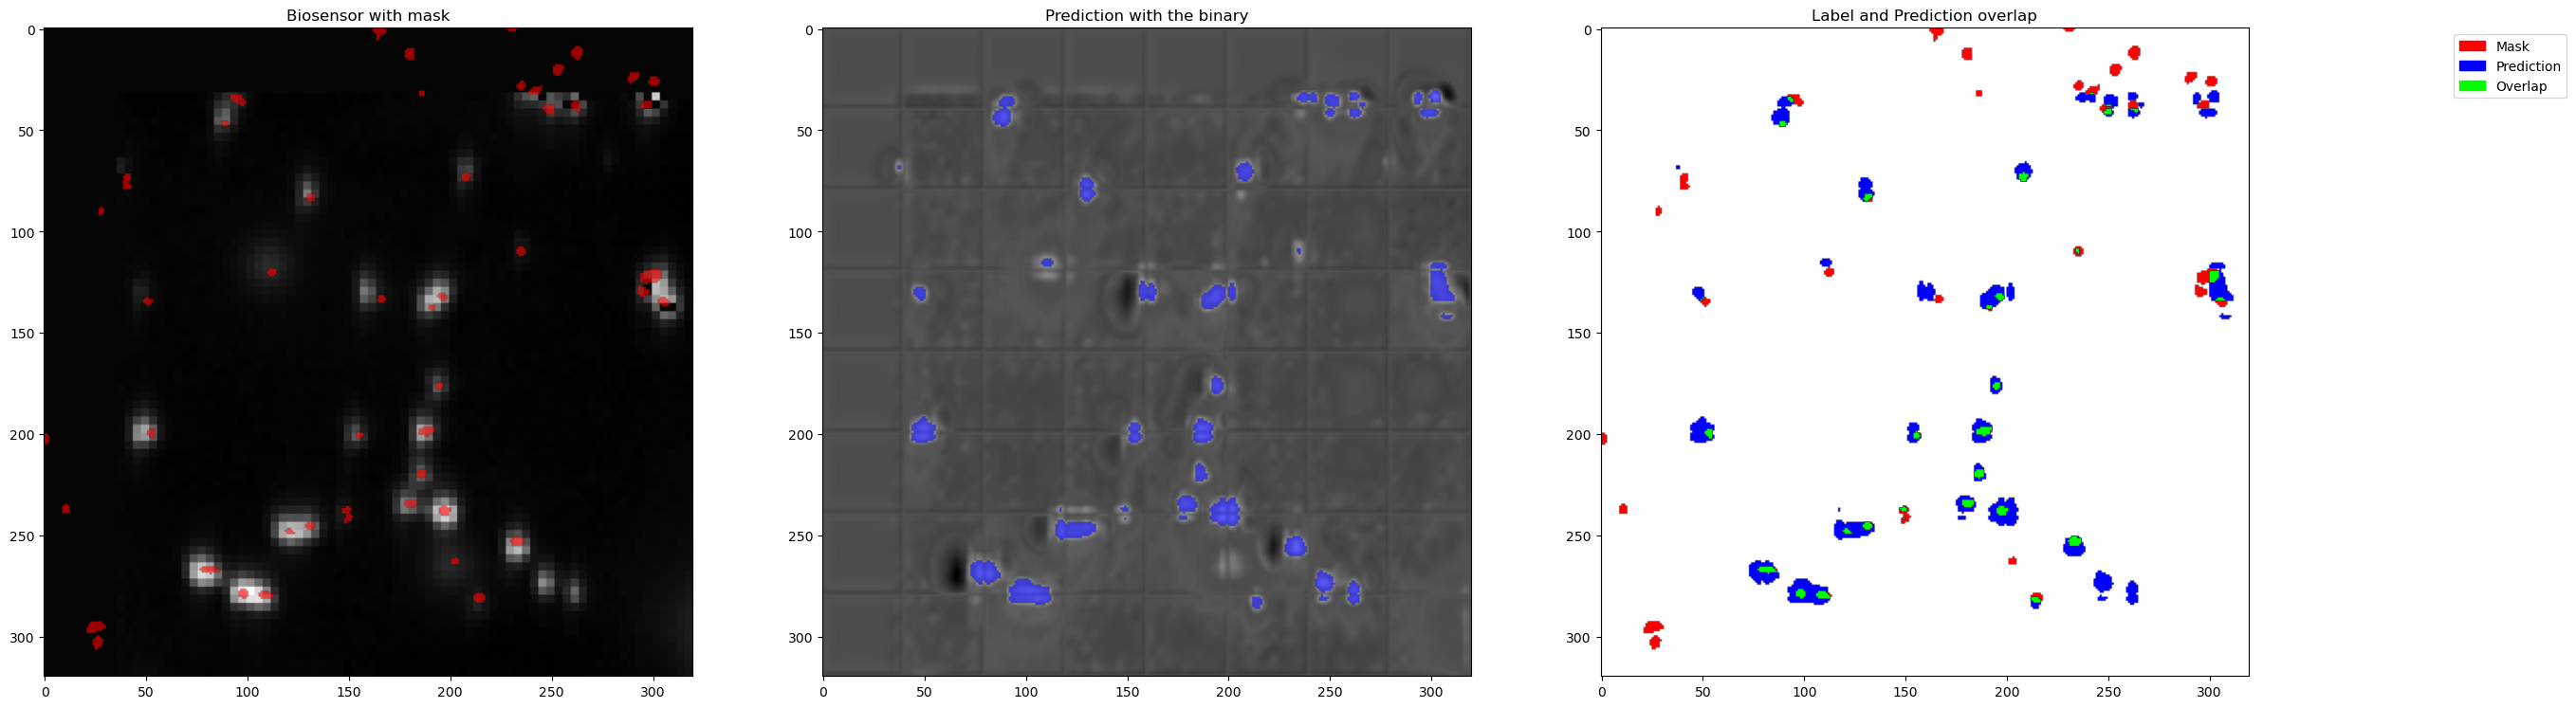

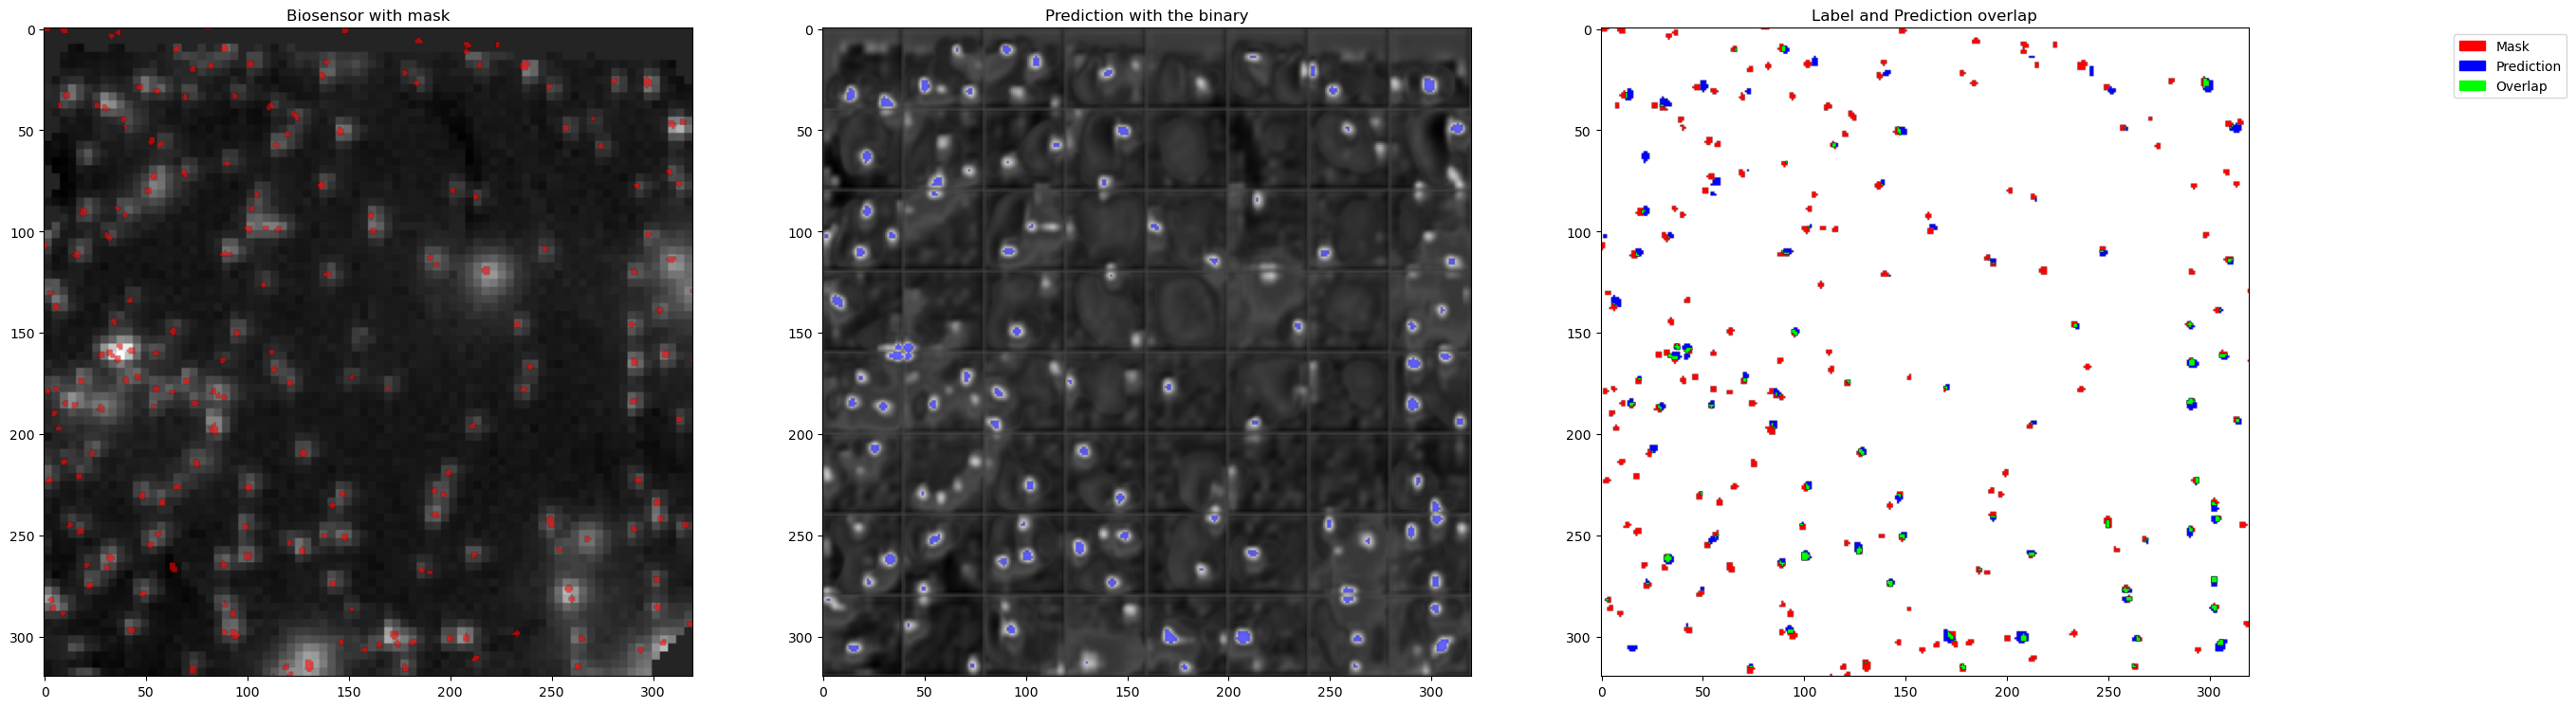

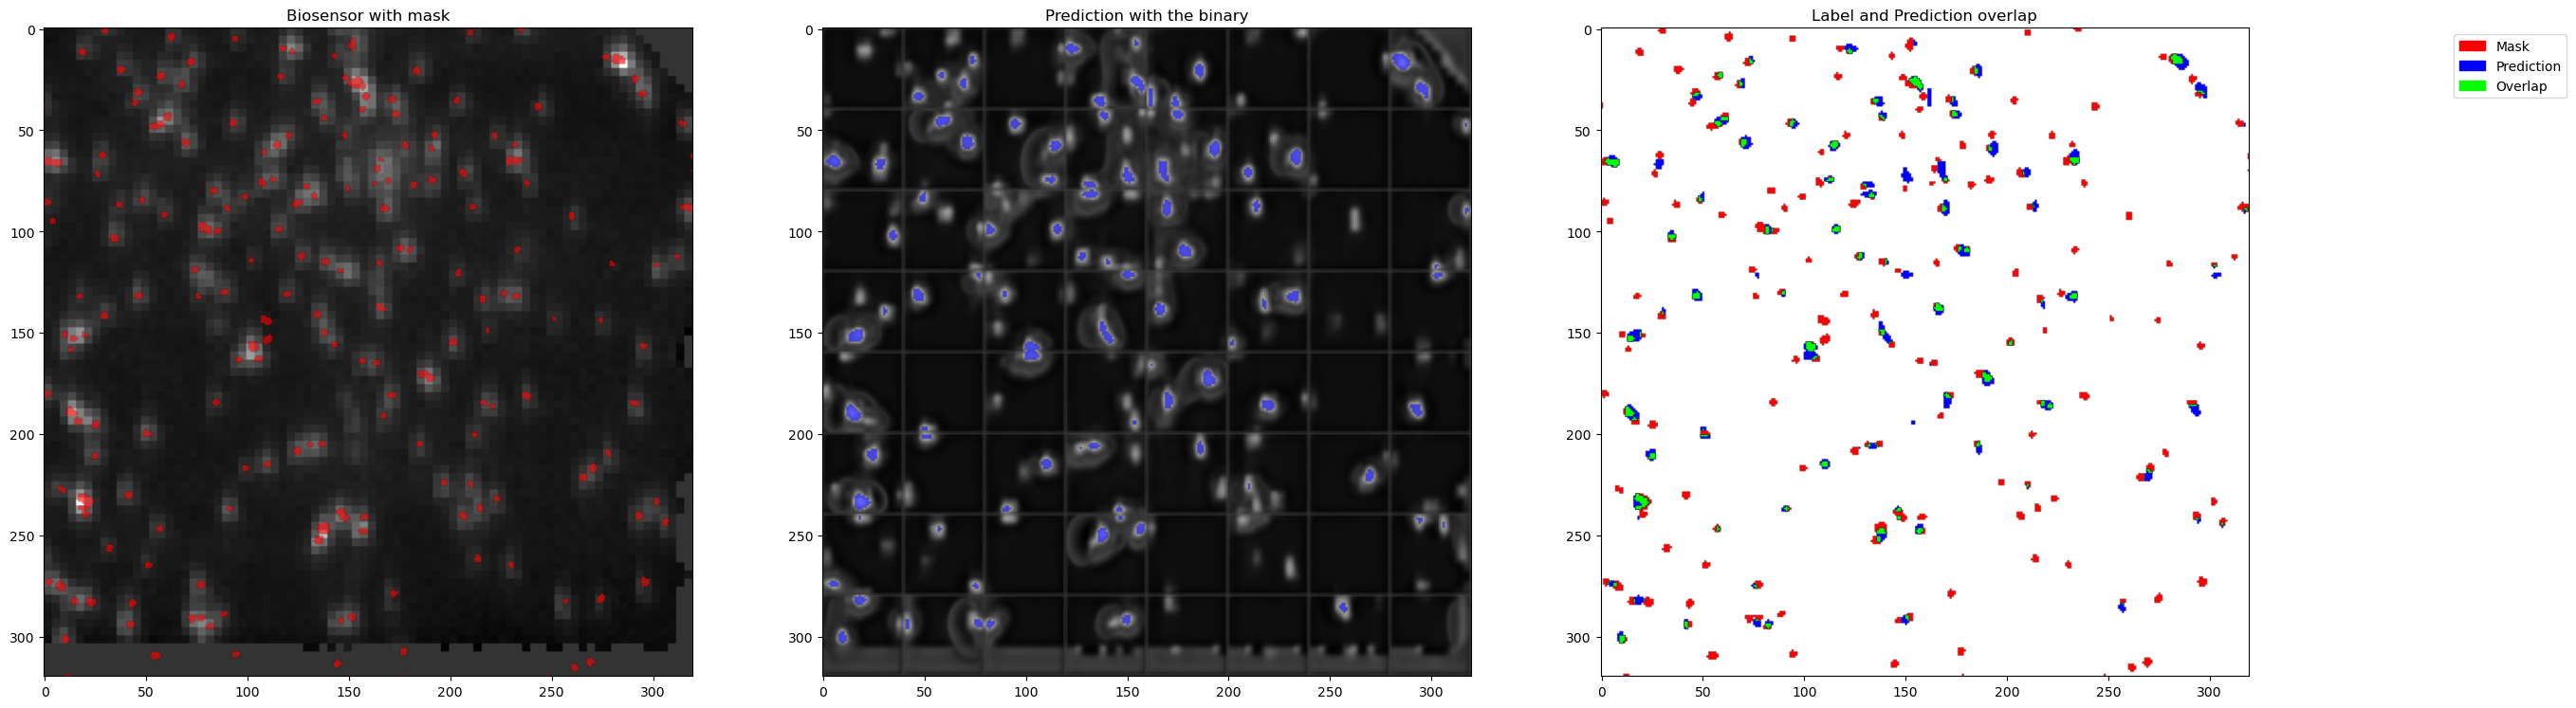

In [7]:
for batch_idx, (data, labels) in enumerate(test_loader):
    data = data.to(device)
    labels = labels.to(device)

    batch_size, tile_num, channels, height, width = data.shape
    data = data.view(batch_size * tile_num, channels, height, width)

    predictions = model(data)

    data = data.view(batch_size, tile_num, channels, height, width)
    batch_size, tile_num, height, width = labels.shape
    predictions = predictions.view(batch_size, tile_num, 1, height, width)

    binary_predictions = (torch.nn.functional.sigmoid(predictions) > 0.5)

    for i in range(len(data)):
        # index = (batch_idx * len(data) + i + 1)
        # print(index)

        label = np.squeeze(labels[i])
        binary_prediction = np.squeeze(binary_predictions[i])
        label = merge_tiles(label)
        binary_prediction = merge_tiles(binary_prediction)
        d = merge_tiles(data[i,:,-1])
        prediction = merge_tiles(predictions[i, :, 0])

        plot_results(d, label, prediction, binary_prediction)

    break


In [ ]:
plot_loader_tiles_data(test_loader, 'Test')